# Moving Company Exploratory Data Analysis

Imports the Google Calendar information from a moving company and describes relevant data.

We need the Python library _icalendar_ to parse the Google Calendar.

In [1]:
from icalendar import Calendar, Event

Let's create a Python dictionary to hold the data from the moving jobs

In [2]:
jobs = {}
i = 0

The text fields (summary and description) have newlines (/n) and $. We need a method for Python to correctly interpret these.

In [3]:
def raw(text):
    return text

The _icalendar_ library parses the calendar. For every _event_ in the calendar, we check to see which fields are present.

In [4]:
def parseKeys(component):
    
      
    if component.has_key('DTSTART'):
            DTSTART = component.get('DTSTART').to_ical()
    else:
        DTSTART = None

    if component.has_key('DTEND'):
        DTEND = component.get('DTEND').to_ical()
    else:
        DTEND = None

    if component.has_key('RRULE'):
        RRULE = component.get('RRULE').to_ical()
    else:
        RRULE = None

    if component.has_key('DTSTAMP'):
        DTSTAMP = component.get('DTSTAMP').to_ical()
    else:
        DTSTAMP = None

    if component.has_key('UID'):
        UID = component.get('UID').to_ical()
    else:
        UID = None

    if component.has_key('CREATED'):
        CREATED = component.get('CREATED').to_ical()
    else:
        CREATED = None

    if component.has_key('DESCRIPTION'):
        DESCRIPTION = raw(component.get('DESCRIPTION').to_ical())
    else:
        DESCRIPTION = None

    if component.has_key('LAST-MODIFIED'):
        LASTMODIFIED = component.get('LAST-MODIFIED').to_ical()
    else:
        LASTMODIFIED = None

    if component.has_key('LOCATION'):
        LOCATION = component.get('LOCATION').to_ical()
    else:
        LOCATION = None

    if component.has_key('SEQUENCE'):
        SEQUENCE = component.get('SEQUENCE').to_ical()
    else:
        SEQUENCE = None

    if component.has_key('SUMMARY'):
        SUMMARY = raw(component.get('SUMMARY').to_ical())
    else:
        SUMMARY = None

    if component.has_key('TRANSP'):
        TRANSP = component.get('TRANSP').to_ical()
    else:
        TRANSP = None


    return [DTSTART,
            DTEND,
            RRULE,
            DTSTAMP,
            UID,
            CREATED,
            DESCRIPTION,
            LASTMODIFIED,
            LOCATION,
            SEQUENCE,
            SUMMARY,
            TRANSP]

Now go through the file and parse the moving jobs into the dictionary

In [5]:
fileName = 'vectormovingsd@gmail.com.ics'

with open(fileName,'rb') as fp:
    gcal = Calendar.from_ical(fp.read())
    for component in gcal.walk():
    
        if component.name == 'VEVENT':
         
            jobs[i] = parseKeys(component)

            i += 1
    
fp.close()

Let's put the jobs into Pandas

In [6]:
import pandas as pd

In [7]:
dfJobs = pd.DataFrame.from_dict(jobs, orient='index')
dfJobs.columns = ['DTSTART',
                  'DTEND',
                  'RRULE',
                  'DTSTAMP',
                  'UID',
                  'CREATED',
                  'DESCRIPTION',
                  'LASTMODIFIED',
                  'LOCATION',
                  'SEQUENCE',
                  'SUMMARY',
                  'TRANSP']

In [8]:
del jobs   # Free up memory

Let's convert the time/date stamps to correct format.

In [13]:
dfJobs['DTSTART'] = pd.to_datetime(dfJobs['DTSTART'])
dfJobs['DTEND'] = pd.to_datetime(dfJobs['DTEND'])
dfJobs['DTSTAMP'] = pd.to_datetime(dfJobs['DTSTAMP'])
dfJobs['CREATED'] = pd.to_datetime(dfJobs['CREATED'])
dfJobs['LASTMODIFIED'] = pd.to_datetime(dfJobs['LASTMODIFIED'])

In [14]:
dfJobs

,DTSTART,DTEND,RRULE,DTSTAMP,UID,CREATED,DESCRIPTION,LASTMODIFIED,LOCATION,SEQUENCE,SUMMARY,TRANSP
0,2013-08-17 15:00:00,2013-08-17 16:00:00,None,2016-11-29 12:31:58,ADD8F2DD-BFEC-4BF8-935F-D8AC24FCBBA8,2013-08-16 00:08:29,7 hours =$975\n15%=$146.25\nJllano@sdsp.net,2013-08-18 17:53:08,972 broadway 91911 building bihind 970 to 2811...,0,$130/hr $65 gas John Llano 619-520-3564\; 619-...,OPAQUE
1,2013-08-18 22:00:00,2013-08-18 23:00:00,None,2016-11-29 12:31:58,5BB18929-7974-4C88-9C53-95588D841D7D,2013-08-18 17:35:50,4:15 $306\n15%- $46.00,2013-08-19 20:27:06,7864 avenida navidad San Diego 92122 #195 to 8...,0,$65 $30 kar khe 832-466-5649 858-663-5613,OPAQUE
2,2013-08-18 20:30:00,2013-08-18 21:30:00,None,2016-11-29 12:31:58,97vcl68nn3potk63j78ds7vs54@google.com,2013-08-19 20:31:03,,2013-08-19 20:31:03,,0,Send 146.25+46= 192.25,OPAQUE
3,2013-08-19 19:00:00,2013-08-19 20:00:00,None,2016-11-29 12:31:58,B7461062-4494-4A2D-8E78-5538A8E980DD,2013-08-15 20:51:30,Ao.dawson88@gmail.com\nPark on beech st \n4 ho...,2013-08-26 00:35:09,1455 kertner blvd apt526 92101 to 801 ash st a...,1,$65 $30 Alex Dawson 928-301-3402,OPAQUE
4,2013-08-20 15:00:00,2013-08-20 16:00:00,None,2016-11-29 12:31:58,uitttdtrjts4vermju9k0vtf5c@google.com,2013-08-18 00:58:34,"$15 wardrobes\n3 hours\, 3wardrobes \n15% $37.05",2013-08-26 00:39:28,707 10-th ave san diego ca 92101 to storage se...,2,Andrew Garry 860-705-4143 $65 $20 5% off,OPAQUE
5,2013-08-20 15:00:00,2013-08-20 16:00:00,None,2016-11-29 12:31:58,2i941ljktu1raatvg1dlgvk1h0@google.com,2013-08-19 18:57:51,Mazi7474@yahoo.com\n19.5 hrs ( 5% off)\n15%$20...,2013-08-26 00:40:42,3435 capri way unit 1 oceanside ca 92056 to 21...,1,Mahsa Ziadloo 760-846-5094 760-846-5097 $140 $65,OPAQUE
6,2013-08-20 21:00:00,2013-08-20 22:00:00,None,2016-11-29 12:31:58,222F6FB4-22EB-4FA2-890D-F661709D98D2,2013-08-19 21:16:00,3 hours\n15%$33.75,2013-08-26 00:41:21,#224 11549 Windcrest lane 92128 to storage.,0,Alene Mcbride 858-568-3848 $65 $30,OPAQUE
7,2013-08-21 17:00:00,2013-08-21 18:00:00,None,2016-11-29 12:31:58,btfvh5trm4924q1thqdedlaslg@google.com,2013-08-22 01:42:46,3 hours \n$31.5,2013-08-26 00:42:13,6586 embrosia dr #5405 san diego 92124,1,Daby Davis 702-715-5801 $65 $15,OPAQUE
8,2013-08-23 14:00:00,2013-08-23 15:00:00,None,2016-11-29 12:31:58,0g22cflo9jscgjlkedoeca7jd4@google.com,2013-08-23 01:47:30,mosb_33@hotmail.com\n3 hours\n$33.75,2013-08-26 00:42:50,6699 beadnell apt 241 san diego 92117 to 910 d...,0,Nouf Barasayn 858-717-3392 $65 $30,OPAQUE
9,2013-08-23 17:12:00,2013-08-23 18:12:00,None,2016-11-29 12:31:58,5FF5E7A1-4FD4-4B93-8107-C2033BC6D12E,2013-08-23 16:52:58,4 hr\n$44.25,2013-08-26 00:44:18,Carlos Mantoya 832-712-4685 $65 $35,0,Carlos Mantoya 832-712-4685 $65 $35,OPAQUE


In [15]:
dfJobs.describe()

,DTSTART,DTEND,RRULE,DTSTAMP,UID,CREATED,DESCRIPTION,LASTMODIFIED,LOCATION,SEQUENCE,SUMMARY,TRANSP
count,4015,4014,22,4015,4015,4015,4015,4015,4015,4015,4015,4015
unique,2552,3273,19,2,4003,3988,3385,3979,1166,18,3866,2
top,2016-06-30 15:00:00,2016-07-01 01:00:00,FREQ=WEEKLY;BYDAY=WE,2016-11-29 12:31:58,oqfubfu24hikhilbdfoi32gcco@google.com,2015-10-07 19:11:08,,2016-10-15 21:37:15,,0,[BROKEN],OPAQUE
freq,10,7,2,3294,5,10,538,6,2789,2448,15,3989
first,2013-08-17 15:00:00,2013-08-17 16:00:00,NaN,2016-11-29 12:31:58,NaN,2013-08-15 20:51:30,NaN,2013-08-18 17:53:08,NaN,NaN,NaN,NaN
last,2016-12-31 17:00:00,2016-12-31 23:00:00,NaN,2016-11-29 12:31:59,NaN,2016-11-29 00:57:30,NaN,2016-11-29 00:57:30,NaN,NaN,NaN,NaN


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals


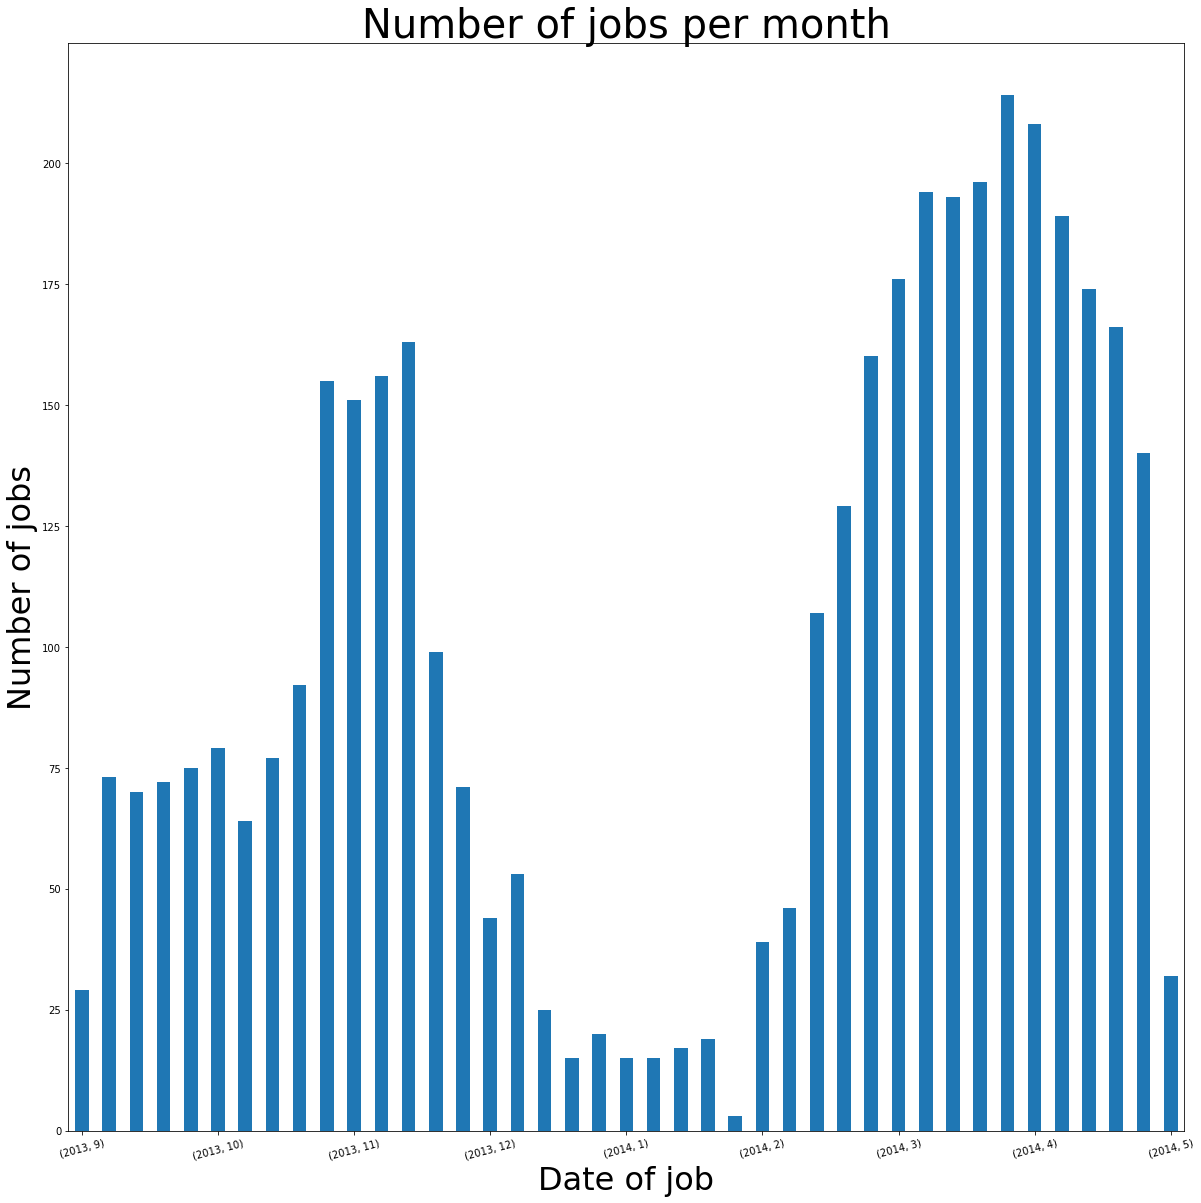

In [45]:
ax = dfJobs['DTSTART'].groupby([dfJobs['DTSTART'].dt.year, dfJobs['DTSTART'].dt.month]).count().plot(kind="bar", 
                                                                                                     rot=15,
                                                                                                    figsize=(20,20));
ax.xaxis.set_major_locator(loc);
plt.xlabel('Date of job', fontsize=32);
plt.ylabel('Number of jobs', fontsize=32);
plt.title('Number of jobs per month', fontsize=40);